# 最小化的 Flow-based 模型

- 使用簡單 affine coupling layer
- 概念與 RealNVP、Glow 完全一致，只是簡化版。

In [2]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-11-20 00:40:49--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 108.177.12.113, 108.177.12.139, 108.177.12.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.12.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-11-20 00:40:49--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.12.132, 2607:f8b0:400c:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  49.2MB/s    in 0.4s    

2025-11-20 00:40:

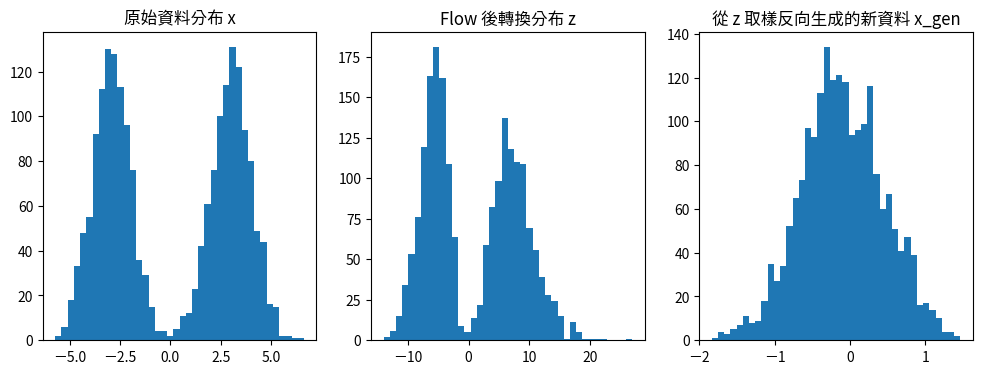

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# === 1. 生成雙峰分布資料 ===
n = 2000
x = torch.cat([
    torch.randn(n//2) * 1 + (-3),
    torch.randn(n//2) * 1 + (3)
]).unsqueeze(1)

# === 2. Flow 的簡單 Coupling Layer ===
class SimpleFlow(nn.Module):
    def __init__(self):
        super().__init__()
        self.s = nn.Sequential(nn.Linear(1, 16), nn.ReLU(), nn.Linear(16, 1))
        self.t = nn.Sequential(nn.Linear(1, 16), nn.ReLU(), nn.Linear(16, 1))

    def forward(self, x):
        s = self.s(x)
        t = self.t(x)
        z = x * torch.exp(s) + t
        log_det = s.sum()
        return z, log_det

    def inverse(self, z):
        # numerical inverse (簡易)
        x = z.clone()
        for _ in range(20):
            s = self.s(x)
            t = self.t(x)
            x = (z - t) * torch.exp(-s)
        return x

flow = SimpleFlow()

# === 3. 將複雜分布 x 映射到簡單分布 z ===
z, _ = flow(x)

# === 4. 從 N(0,1) 取樣並反向生成新資料 ===
z_sample = torch.randn_like(z)
x_gen = flow.inverse(z_sample)

# === 5. 視覺化 ===
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("原始資料分布 x")
plt.hist(x.detach().numpy(), bins=40)

plt.subplot(1,3,2)
plt.title("Flow 後轉換分布 z")
plt.hist(z.detach().numpy(), bins=40)

plt.subplot(1,3,3)
plt.title("從 z 取樣反向生成的新資料 x_gen")
plt.hist(x_gen.detach().numpy(), bins=40)

plt.show()

SimpleFlow 是一個簡單的 仿射耦合層 (affine coupling layer)，它是 Flow-based 模型（例如 RealNVP、Glow）中的一個基本構件

它的主要目標是將一個複雜的資料分佈 x 轉換為一個更容易處理的簡單分佈 z（例如高斯分佈），同時能夠計算這種轉換的雅可比行列式對數（log-determinant of the Jacobian），這對於訓練 Flow-based 模型來說至關重要。

這個類別包含了以下幾個主要部分：

__init__(self)：初始化方法

它定義了兩個小型的神經網路：self.s 和 self.t。

self.s (scale 縮放) 和 self.t (translation 平移) 都由兩個全連接層（nn.Linear）和一個 ReLU 激活函數組成。它們都接收一個 1 維的輸入，並輸出一個 1 維的結果。
self.s 用來學習轉換中的縮放因子，self.t 用來學習平移因子。


forward(self, x)：前向傳播方法

這個方法接收原始資料 x 作為輸入。
它首先通過 self.s(x) 和 self.t(x) 計算出與 x 相關的縮放因子 s 和平移因子 t。
然後，它使用仿射轉換公式將 x 轉換為 z：z = x * torch.exp(s) + t。
這裡使用 torch.exp(s) 是為了確保縮放因子是正數，因為在可逆轉換中，縮放因子必須為正。
同時，它計算了轉換的雅可比行列式對數 (log_det)：log_det = s.sum()。
在這種簡單的仿射耦合層中，雅可比矩陣是一個對角矩陣，對角線上的元素是 exp(s)。因此，雅可比行列式是所有 exp(s) 的乘積，其對數就是所有 s 的和。這個值對於計算機率密度變換非常重要。

最後，它返回轉換後的分佈 z 和 log_det。


inverse(self, z)：逆向傳播方法

這個方法接收轉換後的分佈 z 作為輸入，目標是將其逆向轉換回原始資料 x。

由於 s 和 t 本身是 x 的函數（s(x) 和 t(x)），所以無法直接代數求解 x = (z - t) / exp(s)。因此，這裡採用了一個數值迭代的方式來近似逆轉換。

它從 x = z 開始，迭代 20 次，每次都用當前的 x 值來計算 s(x) 和 t(x)，然後更新 x = (z - t) * torch.exp(-s)。

這種迭代方法可以逐步逼近真正的逆轉換，儘管它只是一個近似值。

總結來說，SimpleFlow 提供了一種可逆的轉換機制，能夠將資料從一個分佈映射到另一個分佈，並且可以計算轉換過程中的機率密度變化，這正是 Flow-based 模型的核心。